<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Wearable Device Data

In this section, we'll build and evaluate a deep learning models to predict if someone is in a state of stress or not based on data from a wearable device. We'll be using a combination of fully connected, LSTM, CNN, and Transformer layers in our model to capture the sequential nature of the data and the long-term dependencies within it. The final output of our model will be a probability between 0 and 1, where values closer to 1 indicate a higher likelihood of stress.

First, we'll prepare our data by splitting it into training, validation, and testing sets, and then we'll normalize the data to ensure that our model is able to learn from it effectively. We'll also use a class weight to give the minority class a weight boost to address class imbalance.

Finally, we'll train and evaluate our model on the testing set and compute various metrics such as accuracy, precision, recall, and F1-score to measure its performance.

## About the data
The data being used in this section is the preprocessed data where specific features from the physiological data has been extracted. Further statistical features will be extracted to produce the final 

- Download the [preprocessed data](https://drive.google.com/file/d/1KuIc5ypFB30McV7tl3ziwQndEIjvtgBJ/view?usp=share_link)(1.81GB) stored in a pickle (.pkl) file.
- Save in a Google Drive directory called `stress-prediction`
- Follow the instructions to load the data below. What it does:
  - Mount Google Drive with the downloaded pre-processed data into a folder `stress-prediction`. We can access the data stored in your Google Drive
  - Set the working directory to the root folder of our project on Google Drive
  - Load the pickled data using joblib

In [40]:
# Import required libraries
import os
import pickle
import joblib

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change working directory to the main file directory on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')

# Define the path of the data directory on Google Drive
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data')

# Load the pickled data using joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle")

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    f

Sure! Here's an example of how you could describe what this code does:

# Exploratory Data Analysis
Now that we have loaded our pickled data, let's take a look at its structure. The 'data' variable is a list of two elements: a pandas dataframe and a numpy array.We can access the dataframe using `data[0]`. To get information about the the first subject's preprocessed data.

In [41]:
# Structure of single dataframe in the list
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [109]:
# Find the size and length of each dataframe
import pandas as pd

# Calculate duration of each dataframe in minutes
for i, df in enumerate(data):
    duration = len(df) / (700 * 60)
    #print(f"Dataframe {i+1} duration: {duration:.2f} minutes")
    df['duration'] = duration
    
# Create a table showing the duration of each dataframe
df_lengths = pd.DataFrame({'Subject': [f"{i}" for i in range(len(data))],
                           'Observations': [len(df) for df in data],
                           '(min)': [round(df['duration'][0]) for df in data]})
print(df_lengths.to_string(index=False))

Subject  Observations  (min)
      0       3847200     92
      1       3883600     92
      2       3875900     92
      3       3663100     87
      4       3941700     94
      5       3676400     88
      6       4144000     99
      7       4255300    101
      8       4545100    108
      9       4496100    107
     10       4380600    104
     11       4949700    118
     12       3666600     87
     13       3826200     91
     14       3656100     87


In [46]:
data[0].describe()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
count,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06
mean,1.479597e+01,8.773488e-07,9.201702e+01,3.477422e+01,1.319141e-01
std,5.429806e+00,5.118602e-03,1.541436e+01,4.796361e-01,3.383974e-01
min,2.319673e+00,-5.590441e-02,5.391528e+01,3.365948e+01,0.000000e+00
25%,1.046479e+01,-1.277041e-03,7.972357e+01,3.438724e+01,0.000000e+00
50%,1.530387e+01,-6.004727e-05,9.191419e+01,3.461252e+01,0.000000e+00
75%,1.836961e+01,1.148620e-03,1.021086e+02,3.526480e+01,0.000000e+00
max,5.166052e+01,9.205739e-02,1.527273e+02,3.577805e+01,1.000000e+00


In [43]:
# Define helper function to plot the training and validation accuracy and loss
def plot_evaluation(model, file_name):
    '''
    Plots the Training and validation accuracy as well as the training and validation loss
    over the number of epochs specified.

    Args:
    model: history object returned from the fit() method of the Keras model
    file_name: filename to save the plot

    Returns:
    None
    '''
    # Import necessary libraries
    import matplotlib.pyplot as plt
    
    # Get training and validation accuracy and loss from the model history
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs_range = range(1, len(loss) + 1)
    
    # Create subplots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    
    # Plot training and validation accuracy
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    # Plot training and validation loss
    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    
    # Customize the figure
    fig.patch.set_facecolor('white')
    
    # Save the plot and display it
    plt.savefig(f'{file_name}')
    plt.show()

In [44]:
# Define function to evaluate the model and plot the training and validation metrics
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
    '''
    Evaluate a Keras model and plot the training and validation metrics.

    Args:
    model_filepath: path to the Keras model file
    history_filepath: path to the pickle file containing the training history of the model
    val_data: validation data generator
    test_data: testing data generator
    save_plot_path: path to save the plot

    Returns:
    The trained Keras model and the training history object
    '''
    # Import necessary libraries
    from tensorflow.keras.models import load_model
    import joblib
    
    # Load the trained Keras model
    model = load_model(model_filepath)
    
    # Evaluate the model on the validation set
    model_eval_val = model.evaluate(val_data, use_multiprocessing=True, batch_size=batch_size)
    
    # Load the training fit history from the pickle file
    fit_history = joblib.load(history_filepath)
    
    # Plot the training and validation metrics
    plot_evaluation(fit_history, save_plot_path)
    
    # Evaluate the model on the test set and print the validation and test accuracy
    model_eval_test = model.evaluate(test_data, use_multiprocessing=True, batch_size=batch_size)
    print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
    print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
    
    # Return the trained model and the training history object
    return model, fit_history


## Feature Engineering
we will compute statistical features that capture the patterns in the data that are relevant to predicting stress. Specifically, we will compute the mean and standard deviation of EDA over different time intervals using the rolling function.

To compute these features, we define a function called compute_features. This function takes as input a dataframe and a list of columns to exclude from feature computation. It computes rolling mean and standard deviation features for all columns except those in the exclude_cols list. We define two window sizes, 60 seconds and 300 seconds, which correspond to intervals of one and five minutes, respectively.

We apply the compute_features function to each dataframe in the list using a list comprehension, creating a new list of dataframes with the computed features. Finally, we drop any rows with missing values in the resulting dataframes to prepare them for modeling.

In [47]:
# Define a function to compute mean, standard deviation of past 1 and 5 min
def compute_features(df, Hz_sampled, exclude_cols=[]):
    # Create a copy of the input DataFrame
    df = df.copy()

    # Compute rolling mean and standard deviation features for all columns
    # except those in exclude_cols
    windows = [int(60 * Hz_sampled), int(300 * Hz_sampled)]

    for col in df.columns:
        if col not in exclude_cols:
            for window in windows:
                df[f'{col}_mean_{window // Hz_sampled}s'] = df[col].rolling(window=window).mean()
                df[f'{col}_std_{window // Hz_sampled}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    df.dropna(inplace=True)
    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df, 700, ['label']) for df in data]


In [49]:
def trim_and_chop(df, Hz_sampled, duration):
    """
    Trim the length of each subject dataframe to be divisible by 
    the desired sequence length, and remove any excess rows.
    
    Args:
    df (DataFrame): The subject's raw dataframe
    Hz_sampled (int): The frequency of the data
    duration (int): The desired duration of each sequence in seconds

    Returns:
    df_trimmed (DataFrame): The trimmed dataframe
    """
    # Calculate the desired length of each sequence
    target_length = Hz_sampled * duration
    
    # Check if the length of the dataframe is already divisible by the target length
    remainder = len(df) % target_length

    if remainder != 0:
        # Calculate the number of rows to trim from the top and bottom
        top_trim = remainder // 2
        bottom_trim = remainder - top_trim

        # Trim the dataframe
        df_trimmed = df.iloc[top_trim: -bottom_trim]
        return df_trimmed
    else:
        return df


In [50]:
# Size of each dataframe
for i in trimmed_df_list:
  print(len(i))

3570000
3570000
3570000
3360000
3570000
3360000
3780000
3990000
4200000
4200000
3990000
4620000
3360000
3570000
3360000


In [51]:
trimmed_df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570000 entries, 243599 to 3813598
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   RSP_Rate              float64
 1   EDA_Phasic            float64
 2   ECG_Rate              float64
 3   Temp                  float32
 4   label                 int32  
 5   RSP_Rate_mean_60s     float64
 6   RSP_Rate_std_60s      float64
 7   RSP_Rate_mean_300s    float64
 8   RSP_Rate_std_300s     float64
 9   EDA_Phasic_mean_60s   float64
 10  EDA_Phasic_std_60s    float64
 11  EDA_Phasic_mean_300s  float64
 12  EDA_Phasic_std_300s   float64
 13  ECG_Rate_mean_60s     float64
 14  ECG_Rate_std_60s      float64
 15  ECG_Rate_mean_300s    float64
 16  ECG_Rate_std_300s     float64
 17  Temp_mean_60s         float64
 18  Temp_std_60s          float64
 19  Temp_mean_300s        float64
 20  Temp_std_300s         float64
dtypes: float32(1), float64(19), int32(1)
memory usage: 572.0 MB


In [52]:
trimmed_df_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3570000.0,1.461197e+01,5.467430,2.319673,10.168142,1.500523e+01,18.249221,51.660517
EDA_Phasic,3570000.0,1.652568e-06,0.005241,-0.055904,-0.001296,-6.506017e-05,0.001155,0.092057
ECG_Rate,3570000.0,9.173783e+01,15.774183,53.915276,79.151481,9.108286e+01,102.182506,152.727273
Temp,3570000.0,3.482161e+01,0.454159,34.136749,34.414764,3.464474e+01,35.306641,35.778046
label,3570000.0,1.421569e-01,0.349211,0.000000,0.000000,0.000000e+00,0.000000,1.000000
RSP_Rate_mean_60s,3570000.0,1.463973e+01,3.476750,5.527036,12.206068,1.526531e+01,17.405408,22.693054
RSP_Rate_std_60s,3570000.0,3.843627e+00,1.723224,0.875032,2.514544,3.613787e+00,4.842836,9.056521
RSP_Rate_mean_300s,3570000.0,1.478697e+01,2.597034,7.838479,13.046097,1.558837e+01,17.080891,18.760963
RSP_Rate_std_300s,3570000.0,4.612333e+00,1.121828,2.299659,3.677238,4.585956e+00,5.536561,7.192086
EDA_Phasic_mean_60s,3570000.0,7.119763e-08,0.000234,-0.002361,-0.000035,1.647864e-07,0.000033,0.002526


In [53]:
trimmed_df_list[0].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,RSP_Rate_mean_60s,RSP_Rate_std_60s,RSP_Rate_mean_300s,RSP_Rate_std_300s,EDA_Phasic_mean_60s,...,EDA_Phasic_mean_300s,EDA_Phasic_std_300s,ECG_Rate_mean_60s,ECG_Rate_std_60s,ECG_Rate_mean_300s,ECG_Rate_std_300s,Temp_mean_60s,Temp_std_60s,Temp_mean_300s,Temp_std_300s
243599,17.250649,-0.001230,87.339712,34.286285,0,18.117939,1.166209,17.439459,3.793102,-0.000006,...,3.911796e-07,0.001617,94.814792,6.049363,96.764945,6.999736,34.288191,0.031857,34.087082,0.162913
243600,17.251090,-0.001206,87.354605,34.316895,0,18.117877,1.166186,17.439435,3.793087,-0.000006,...,3.857990e-07,0.001617,94.814308,6.049146,96.764877,6.999758,34.288193,0.031857,34.087084,0.162912
243601,17.251531,-0.001181,87.369520,34.309235,0,18.117816,1.166164,17.439410,3.793072,-0.000006,...,3.805120e-07,0.001617,94.813824,6.048929,96.764808,6.999779,34.288195,0.031855,34.087087,0.162912
243602,17.251972,-0.001157,87.384458,34.316895,0,18.117754,1.166142,17.439386,3.793057,-0.000006,...,3.753225e-07,0.001617,94.813341,6.048712,96.764740,6.999801,34.288196,0.031856,34.087090,0.162911
243603,17.252413,-0.001132,87.399418,34.280182,0,18.117693,1.166120,17.439362,3.793041,-0.000006,...,3.702344e-07,0.001617,94.812858,6.048495,96.764672,6.999822,34.288198,0.031852,34.087092,0.162910


In [54]:
## Include Subject
for i, df in enumerate(trimmed_df_list):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

<ipython-input-54-a2895b379715>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject'] = i
<ipython-input-54-a2895b379715>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject'] = df['subject'].astype('category')
<ipython-input-54-a2895b379715>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [55]:
trimmed_df_list[1].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,RSP_Rate_mean_60s,RSP_Rate_std_60s,RSP_Rate_mean_300s,RSP_Rate_std_300s,EDA_Phasic_mean_60s,...,EDA_Phasic_std_300s,ECG_Rate_mean_60s,ECG_Rate_std_60s,ECG_Rate_mean_300s,ECG_Rate_std_300s,Temp_mean_60s,Temp_std_60s,Temp_mean_300s,Temp_std_300s,subject
261799,16.260077,0.001617,88.740037,33.485443,0,17.313104,2.083049,15.456417,3.163742,0.000089,...,0.001951,73.059094,5.300815,71.33251,4.979361,33.484978,0.037924,33.317654,0.130766,1
261800,16.255842,0.001601,88.732659,33.536865,0,17.312927,2.082824,15.456409,3.163737,0.000089,...,0.001951,73.059484,5.301365,71.33259,4.979505,33.484982,0.037922,33.317656,0.130765,1
261801,16.251608,0.001586,88.725267,33.547455,0,17.312750,2.082598,15.456401,3.163733,0.000089,...,0.001951,73.059873,5.301915,71.33267,4.979650,33.484985,0.037921,33.317659,0.130765,1
261802,16.247374,0.001570,88.717860,33.553497,0,17.312573,2.082372,15.456393,3.163729,0.000089,...,0.001951,73.060263,5.302465,71.33275,4.979794,33.484989,0.037920,33.317661,0.130764,1
261803,16.243140,0.001555,88.710438,33.535339,0,17.312396,2.082147,15.456385,3.163725,0.000089,...,0.001951,73.060653,5.303014,71.33283,4.979938,33.484991,0.037920,33.317663,0.130764,1


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Concatenate the dataframes together
df = pd.concat(trimmed_df_list)

# Downsample the dataframe
target_hz = 1
resample_factor = int(700 / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

# Define the percentage split for training, validation, and testing data
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

# Get a list of unique subject IDs
subject_ids = np.unique(df['subject'])

# Randomly shuffle the subject IDs
np.random.shuffle(subject_ids)

# Calculate the number of subjects for each dataset
num_train = int(len(subject_ids) * train_pct)
num_val = int(len(subject_ids) * val_pct)
num_test = int(len(subject_ids)) - num_train - num_val

# Split the subject IDs into training, validation, and testing sets
train_subjects = subject_ids[:num_train]
val_subjects = subject_ids[num_train:num_train+num_val]
test_subjects = subject_ids[num_train+num_val:]

# Split the data into training, validation, and testing sets by subject ID
train_df = df[df['subject'].isin(train_subjects)]
val_df = df[df['subject'].isin(val_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')

<ipython-input-56-12ddb22c64a9>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
<ipython-input-56-12ddb22c64a9>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
<ipython-input-56-12ddb22c64a9>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 243599 to 3802399
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   RSP_Rate              48000 non-null  float64 
 1   EDA_Phasic            48000 non-null  float64 
 2   ECG_Rate              48000 non-null  float64 
 3   Temp                  48000 non-null  float64 
 4   label                 48000 non-null  int32   
 5   RSP_Rate_mean_60s     48000 non-null  float64 
 6   RSP_Rate_std_60s      48000 non-null  float64 
 7   RSP_Rate_mean_300s    48000 non-null  float64 
 8   RSP_Rate_std_300s     48000 non-null  float64 
 9   EDA_Phasic_mean_60s   48000 non-null  float64 
 10  EDA_Phasic_std_60s    48000 non-null  float64 
 11  EDA_Phasic_mean_300s  48000 non-null  float64 
 12  EDA_Phasic_std_300s   48000 non-null  float64 
 13  ECG_Rate_mean_60s     48000 non-null  float64 
 14  ECG_Rate_std_60s      48000 non-null  float64 


In [58]:
print(train_df['subject'].unique())
print(val_df['subject'].unique())
print(test_df['subject'].unique())

[0, 1, 3, 5, 9, 10, 11, 12, 13]
Categories (9, int64): [0, 1, 3, 5, ..., 10, 11, 12, 13]
[7, 8, 14]
Categories (3, int64): [7, 8, 14]
[2, 4, 6]
Categories (3, int64): [2, 4, 6]


In [59]:
train_df['label'].value_counts()

0    41994
1     6006
Name: label, dtype: int64

In [60]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

48000
16500
15600


In [61]:
train_df.shape

(48000, 22)

In [62]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define batch size and sequence length
duration = 5 # minutes
batch_size = 10
seq_length = target_hz * 60 * duration # full length of sequence

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Stride
stride = 1 * target_hz * 60 # 1 minute strides

# Extract values from DataFrame
train_data = train_df.drop(['label', 'subject'], axis=1).values
val_data = val_df.drop(['label', 'subject'], axis=1).values
test_data = test_df.drop(['label', 'subject'], axis=1).values

# Trim front and end of the data
train_data = train_data[:-seq_length]
train_labels = train_df['label'][seq_length:].values
val_data = val_data[:-seq_length]
val_labels = val_df['label'][seq_length:].values
test_data = test_data[:-seq_length]
test_labels = test_df['label'][seq_length:].values

# Create data generators with start_index
train_gen = TimeseriesGenerator(train_data, 
                                train_labels,
                                length=seq_length, 
                                batch_size=batch_size, 
                                shuffle=False)

val_gen = TimeseriesGenerator(val_data, 
                              val_labels,
                              length=seq_length, 
                              batch_size=batch_size)

test_gen = TimeseriesGenerator(test_data, 
                               test_labels,
                               length=seq_length, 
                               batch_size=batch_size)

In [63]:
# This means
# 1. Number of batches (83): This is the total number of batches that the 
# generator will produce during one pass through the dataset (one epoch). Each 
# batch contains batch_size number of samples. In this case, the generator will 
# iterate through the training dataset and produce 83 batches.

# Number of samples (830): This is the total number of samples the generator will 
# process in one epoch. This is calculated by multiplying the number of batches 
# by the batch size (83 * 10).

# Shape of X (10, 300, 20): This describes the shape of the input data (X) for 
# each batch. In this case, each batch will contain 10 samples (the batch size), 
# each sample will have a sequence length of 300 time steps, and each time step 
# will have 20 features.

# Shape of y (10,): This describes the shape of the output data (y) for each 
# batch. In this case, each batch will have 10 output labels, one for each 
# sample in the batch.

In [64]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

Class 0 (Non-stress): 87.49%
Class 1 (Stress): 12.51%


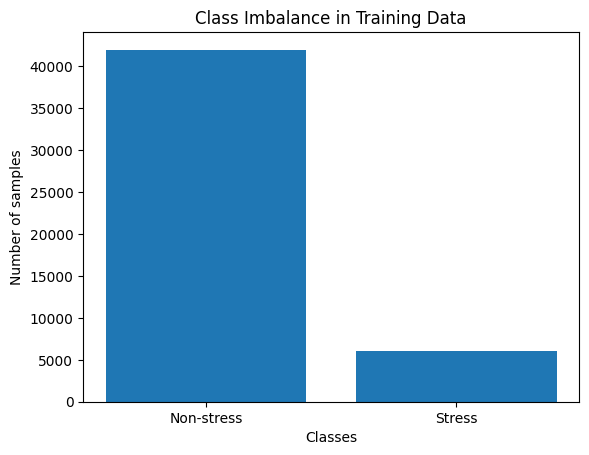

In [65]:
# Class imbalance

# Class weight correction
from sklearn.utils import class_weight

y_train = train_df['label']

import matplotlib.pyplot as plt
import numpy as np

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced', 
                                                   y=y_train)

# Define class weight dictionary
zero_count = class_counts[0]
one_count = class_counts[1]
class_weights_dict = {0: 1 / zero_count, 1: 1 / one_count}

#class_weights_dict = {class_label: class_weight
#                      for class_label, class_weight in zip(unique_classes,  len(y_train) / (2*class_counts))}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.show()

In [66]:
def confusion_matrix_plot(model, data, save_file=None):
    # Confusion Matrix
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)

    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if save_file:
        plt.savefig(f'{save_file}')
    plt.show()


In [67]:
# Classification Report
from sklearn.metrics import classification_report

def classification_report_output(model, data, save_file=None):
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    if save_file:
        report_df.to_csv(save_file, index=True)

    print(report_df)

In [68]:
batch_X, batch_y = train_gen.__getitem__(0)
print(batch_X.shape) # should output (32, 300, 20)
print(batch_y.shape) # should output (32, 1)

(10, 300, 20)
(10,)


In [69]:
print(train_gen[0][0].shape)
# get the first batch of data
x_batch, y_batch = train_gen[0]

no_features = train_gen[0][0].shape
print(no_features[2])

(10, 300, 20)
20


In [70]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

no_features = train_gen[0][0].shape[2]

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, no_features))
x = Flatten()(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 6000)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                96016     
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 96,033
Trainable params: 96,033
Non-trainable params: 0
_________________________________________________________________


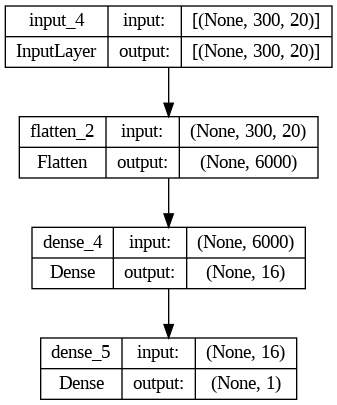

In [71]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_0, to_file='models/model.png', show_shapes=True, show_layer_names=True)


In [72]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [73]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=5),
                        # remove the last batch if not even
                        #steps_per_epoch=len(train_gen)-1
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
4740/4740 [==============================] - 18s 4ms/step - loss: 1.5524e-04 - binary_accuracy: 0.8038 - val_loss: 1.4267 - val_binary_accuracy: 0.9071
Epoch 2/200
4740/4740 [==============================] - 17s 4ms/step - loss: 1.4170e-04 - binary_accuracy: 0.8234 - val_loss: 2.3343 - val_binary_accuracy: 0.8470
Epoch 3/200
4740/4740 [==============================] - 17s 4ms/step - loss: 1.4957e-04 - binary_accuracy: 0.8314 - val_loss: 1.5218 - val_binary_accuracy: 0.9009
Epoch 4/200
4740/4740 [==============================] - 17s 4ms/step - loss: 1.1321e-04 - binary_accuracy: 0.9003 - val_loss: 1.1282 - val_binary_accuracy: 0.9267
Epoch 5/200
4740/4740 [==============================] - 17s 4ms/step - loss: 7.7884e-05 - binary_accuracy: 0.8957 - val_loss: 5.1872 - val_binary_accuracy: 0.6594
Epoch 6/200
4740/4740 [==============================] - 17s 4ms/step - loss: 5.0726e-05 - binary_accuracy: 0.9069 - val_loss: 2.4972 - val_binary_accuracy: 0.8363
Epoch 7/200
4740

1590/1590 [==============================] - 5s 3ms/step - loss: 1.0847 - binary_accuracy: 0.9296


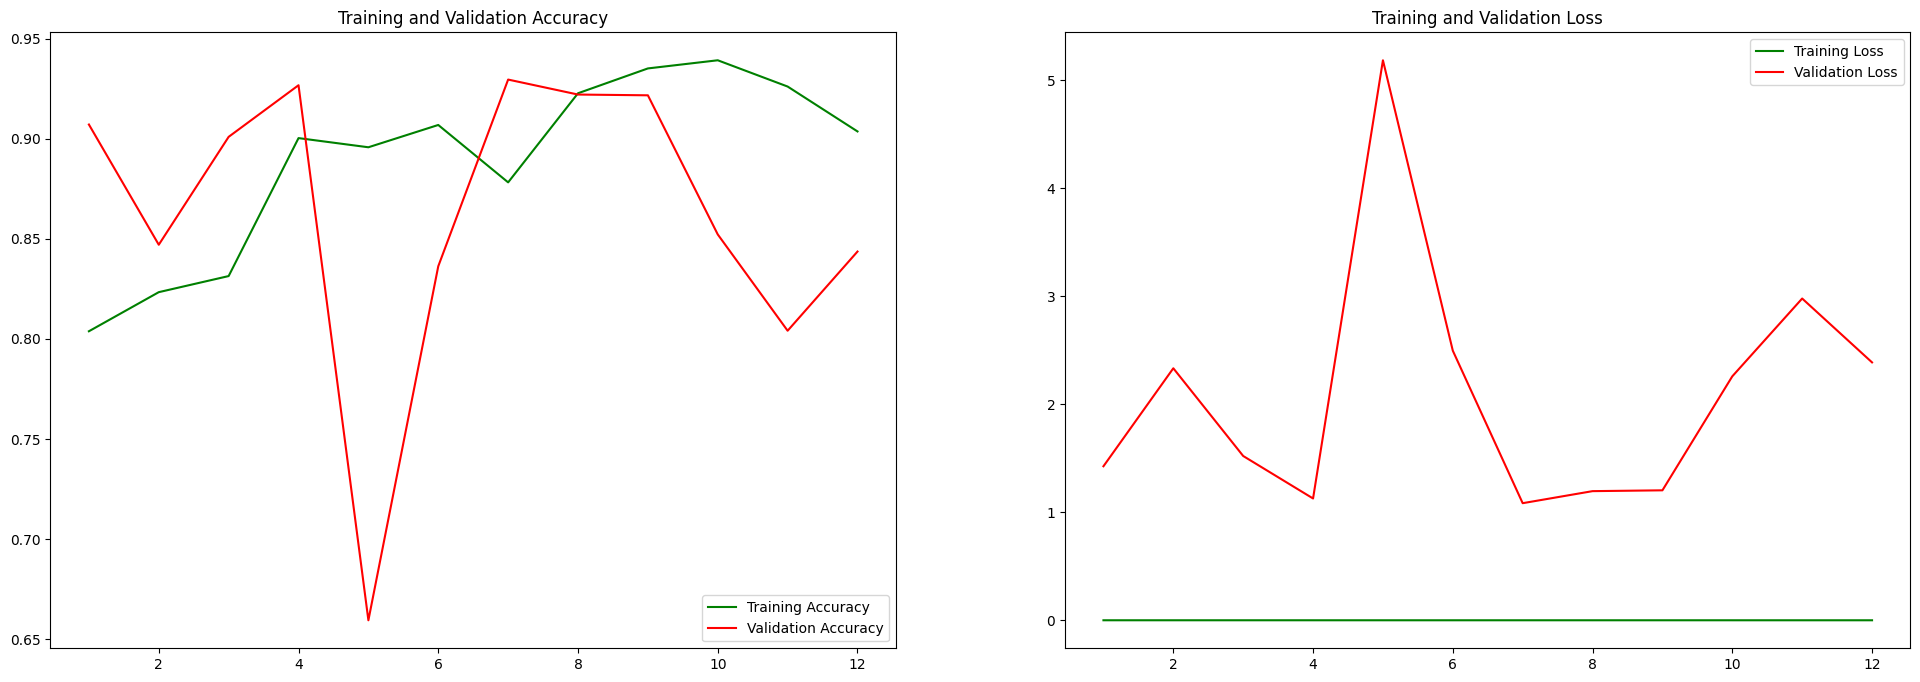

Validation Binary Accuracy is: 0.93
1500/1500 [==============================] - 5s 3ms/step - loss: 4.7879 - binary_accuracy: 0.6846
Testing Binary Accuracy is: 0.68


In [74]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

4740/4740 [==============================] - 7s 1ms/step


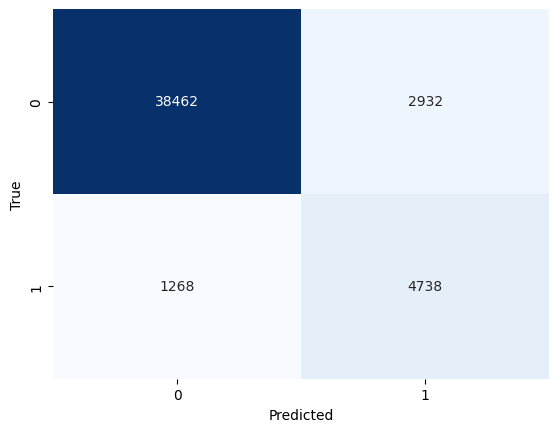

4740/4740 [==============================] - 7s 1ms/step
              precision    recall  f1-score       support
0              0.968085  0.929168  0.948227  41394.000000
1              0.617731  0.788878  0.692893   6006.000000
accuracy       0.911392  0.911392  0.911392      0.911392
macro avg      0.792908  0.859023  0.820560  47400.000000
weighted avg   0.923692  0.911392  0.915874  47400.000000
1590/1590 [==============================] - 2s 1ms/step


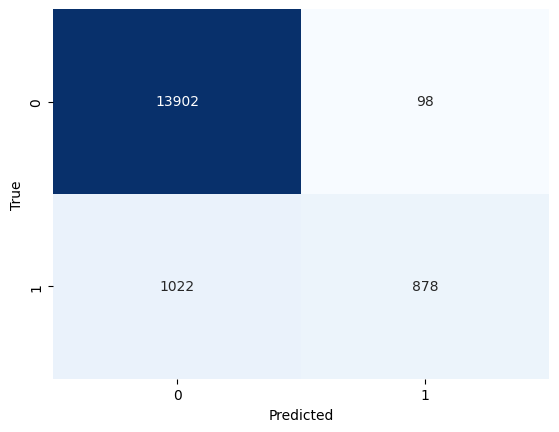

1590/1590 [==============================] - 2s 1ms/step
              precision    recall  f1-score      support
0              0.931520  0.993000  0.961278  14000.00000
1              0.899590  0.462105  0.610570   1900.00000
accuracy       0.929560  0.929560  0.929560      0.92956
macro avg      0.915555  0.727553  0.785924  15900.00000
weighted avg   0.927704  0.929560  0.919369  15900.00000
1500/1500 [==============================] - 2s 1ms/step


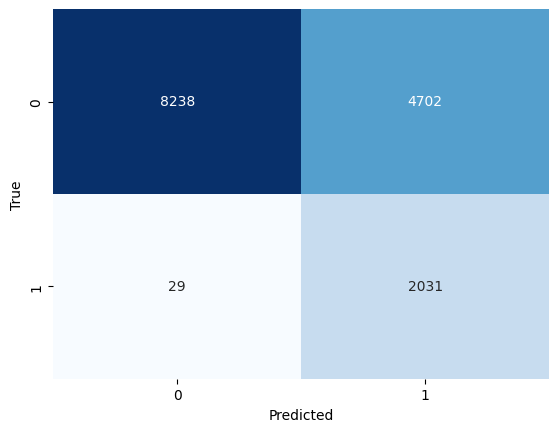

1500/1500 [==============================] - 2s 1ms/step
              precision    recall  f1-score     support
0              0.996492  0.636631  0.776913  12940.0000
1              0.301649  0.985922  0.461958   2060.0000
accuracy       0.684600  0.684600  0.684600      0.6846
macro avg      0.649070  0.811276  0.619436  15000.0000
weighted avg   0.901067  0.684600  0.733659  15000.0000


In [75]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [76]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


In [77]:
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [78]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [79]:

lstm_units_list = [32]
learning_rates_list = [0.001]
class_weight_penalty= [1]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4740/4740 [==============================] - 56s 11ms/step - loss: 1.5571e-05 - binary_accuracy: 0.8223 - val_loss: 0.7210 - val_binary_accuracy: 0.5820
Epoch 2/200
4740/4740 [==============================] - 52s 11ms/step - loss: 1.2476e-05 - binary_acc

1590/1590 [==============================] - 8s 5ms/step - loss: 0.4627 - binary_accuracy: 0.7515


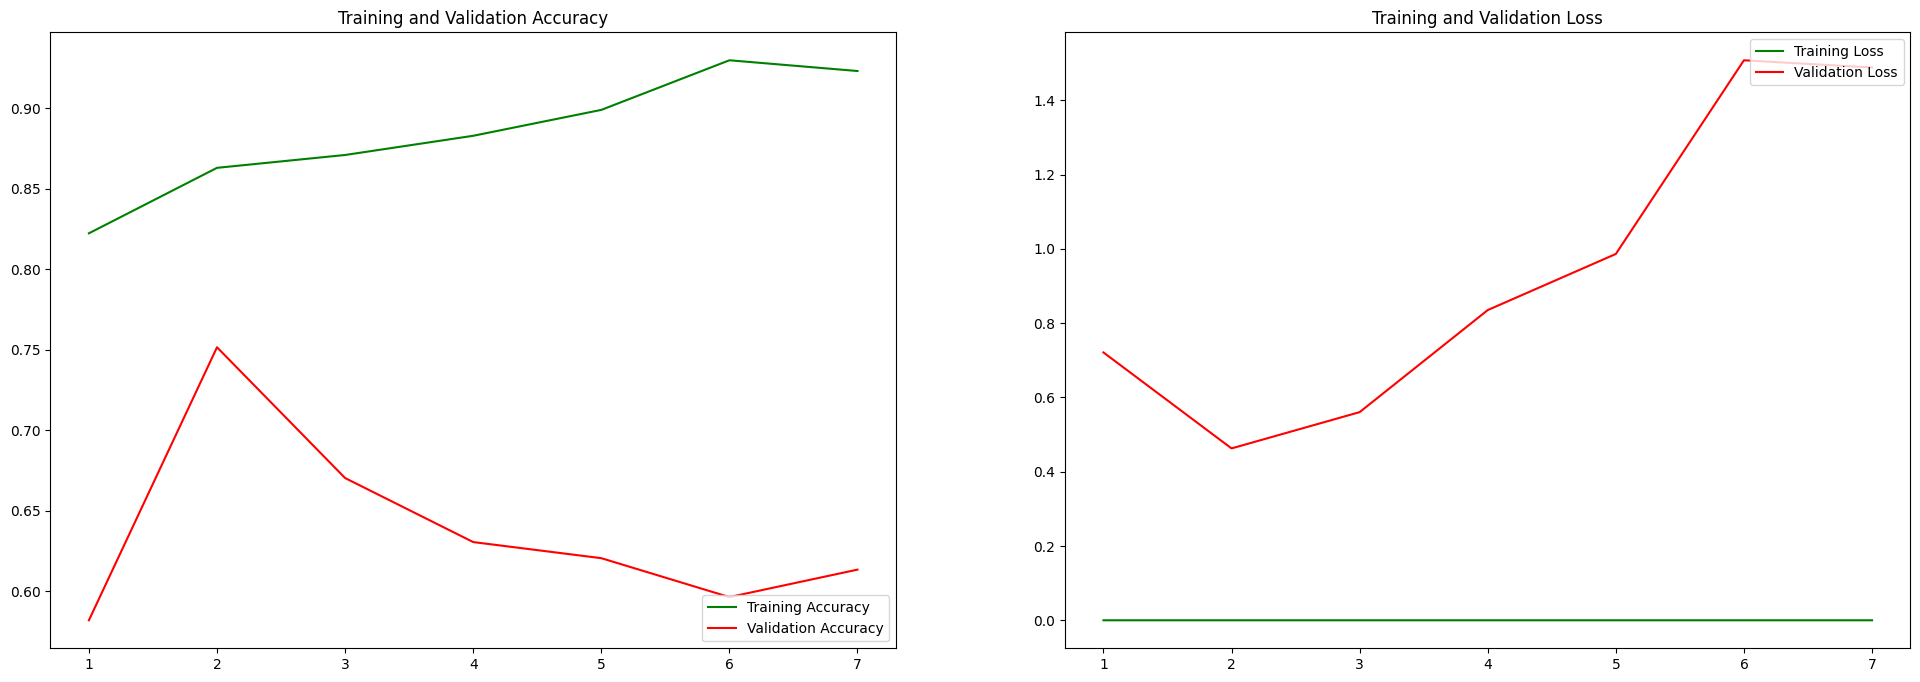

Validation Binary Accuracy is: 0.75
1500/1500 [==============================] - 8s 5ms/step - loss: 1.2264 - binary_accuracy: 0.4636
Testing Binary Accuracy is: 0.46


In [80]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

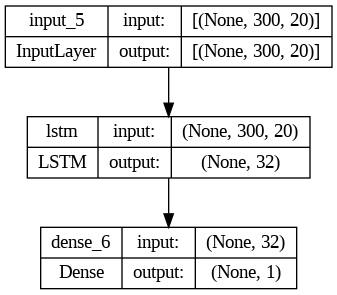

In [81]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_1, to_file='models/model_1_arch.png', show_shapes=True, show_layer_names=True)

4740/4740 [==============================] - 20s 4ms/step


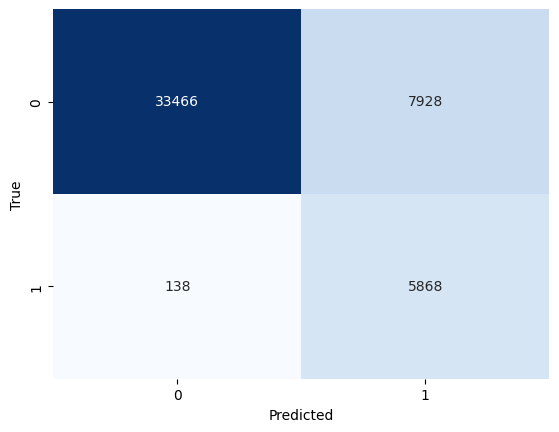

4740/4740 [==============================] - 20s 4ms/step
              precision    recall  f1-score       support
0              0.995893  0.808475  0.892450  41394.000000
1              0.425341  0.977023  0.592667   6006.000000
accuracy       0.829831  0.829831  0.829831      0.829831
macro avg      0.710617  0.892749  0.742559  47400.000000
weighted avg   0.923599  0.829831  0.854465  47400.000000
1590/1590 [==============================] - 7s 4ms/step


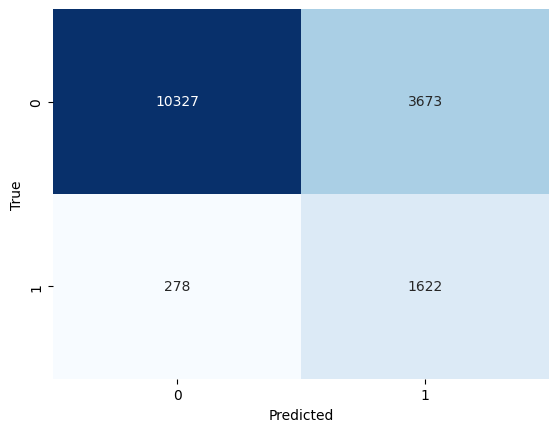

1590/1590 [==============================] - 7s 4ms/step
              precision    recall  f1-score       support
0              0.973786  0.737643  0.839423  14000.000000
1              0.306327  0.853684  0.450869   1900.000000
accuracy       0.751509  0.751509  0.751509      0.751509
macro avg      0.640056  0.795664  0.645146  15900.000000
weighted avg   0.894027  0.751509  0.792992  15900.000000
1500/1500 [==============================] - 6s 4ms/step


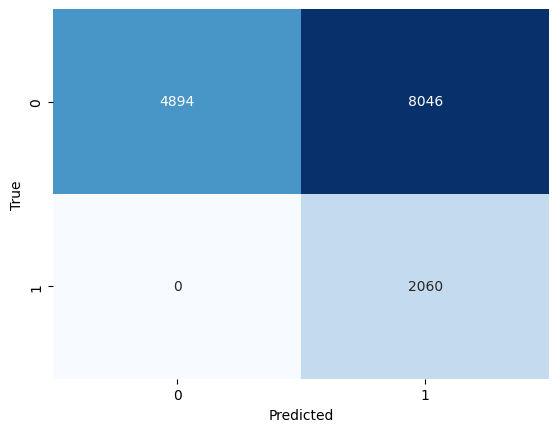

1500/1500 [==============================] - 6s 4ms/step
              precision    recall  f1-score     support
0              1.000000  0.378207  0.548839  12940.0000
1              0.203839  1.000000  0.338649   2060.0000
accuracy       0.463600  0.463600  0.463600      0.4636
macro avg      0.601920  0.689104  0.443744  15000.0000
weighted avg   0.890661  0.463600  0.519973  15000.0000


In [82]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

In [83]:
# Model 2
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, train_gen[0][0].shape[2]),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2, 
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [84]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
#lstm_units_list = [best_lstm_units]
#learning_rates_list = [best_learning_rate]
#class_weight_penalty= [best_penalty]

In [85]:
print(lstm_units_list)
print(learning_rates_list)
print(class_weight_penalty)

[32]
[0.001]
[1]


In [86]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 32)           6784      
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,937
Trainable params: 9,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4740/4740 [==============================] - 92s 19ms/step - loss: 1.8649e-05 - binary_accuracy: 0.7965 - val_loss: 0.593

1590/1590 [==============================] - 14s 8ms/step - loss: 0.3192 - binary_accuracy: 0.8643


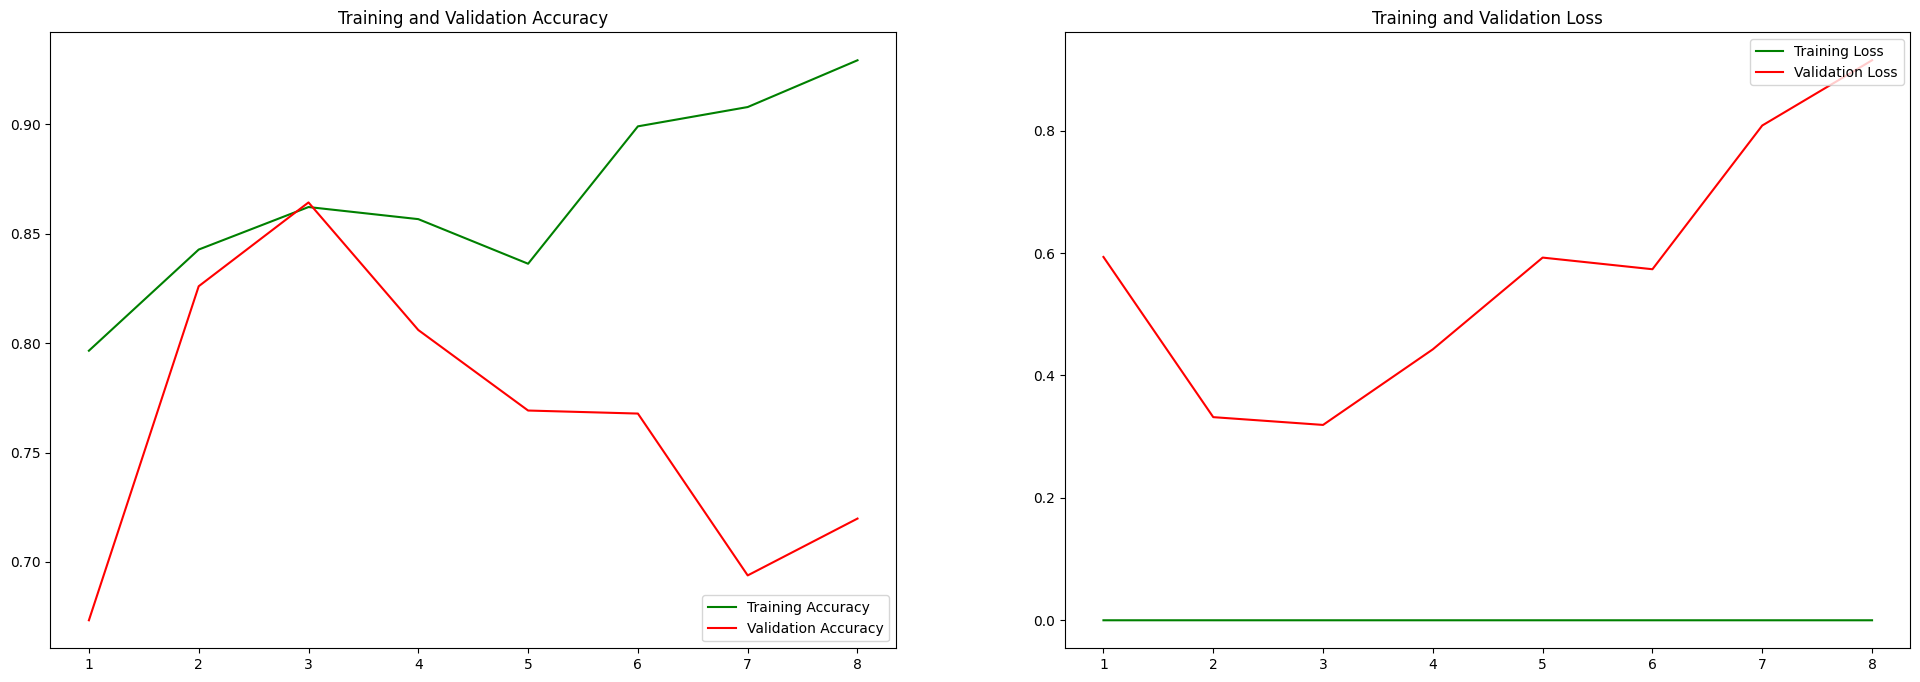

Validation Binary Accuracy is: 0.86
1500/1500 [==============================] - 12s 8ms/step - loss: 1.1109 - binary_accuracy: 0.5257
Testing Binary Accuracy is: 0.53


In [87]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

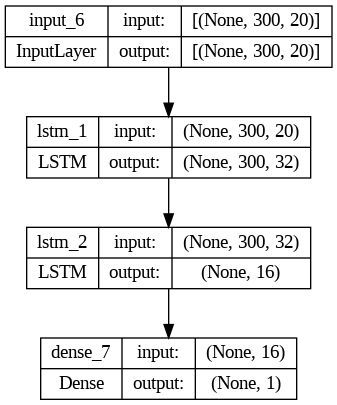

In [88]:
# Plot model visualization
from keras.utils import plot_model

plot_model(model_2, to_file='models/model_2_arch.png', show_shapes=True, show_layer_names=True)

4740/4740 [==============================] - 35s 7ms/step


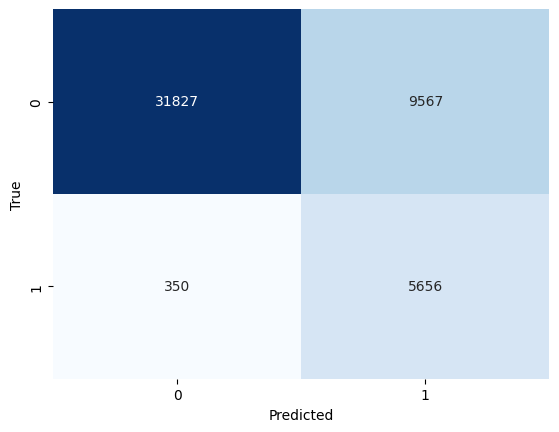

4740/4740 [==============================] - 34s 7ms/step
              precision    recall  f1-score       support
0              0.989123  0.768880  0.865205  41394.000000
1              0.371543  0.941725  0.532856   6006.000000
accuracy       0.790781  0.790781  0.790781      0.790781
macro avg      0.680333  0.855302  0.699031  47400.000000
weighted avg   0.910870  0.790781  0.823093  47400.000000
1590/1590 [==============================] - 11s 7ms/step


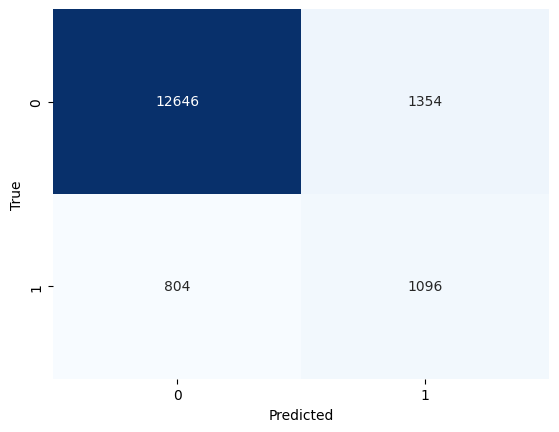

1590/1590 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.940223  0.903286  0.921384  14000.000000
1              0.447347  0.576842  0.503908   1900.000000
accuracy       0.864277  0.864277  0.864277      0.864277
macro avg      0.693785  0.740064  0.712646  15900.000000
weighted avg   0.881326  0.864277  0.871497  15900.000000
1500/1500 [==============================] - 11s 7ms/step


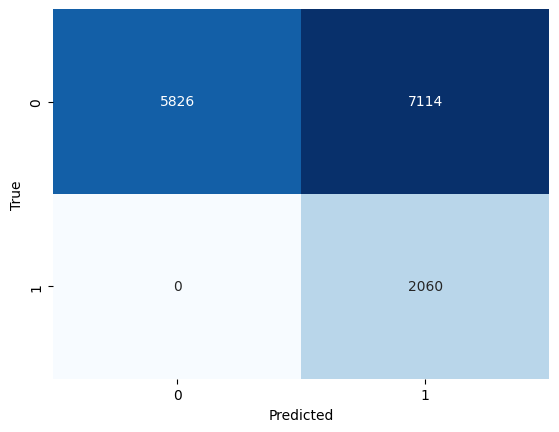

1500/1500 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              1.000000  0.450232  0.620910  12940.000000
1              0.224548  1.000000  0.366744   2060.000000
accuracy       0.525733  0.525733  0.525733      0.525733
macro avg      0.612274  0.725116  0.493827  15000.000000
weighted avg   0.893505  0.525733  0.586005  15000.000000


In [89]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

In [90]:
# Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, train_gen[0][0].shape[2]),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [91]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [92]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 32)           6784      
                                                                 
 batch_normalization (BatchN  (None, 300, 32)          128       
 ormalization)                                                   
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 de

1590/1590 [==============================] - 14s 8ms/step - loss: 0.6568 - binary_accuracy: 0.7692


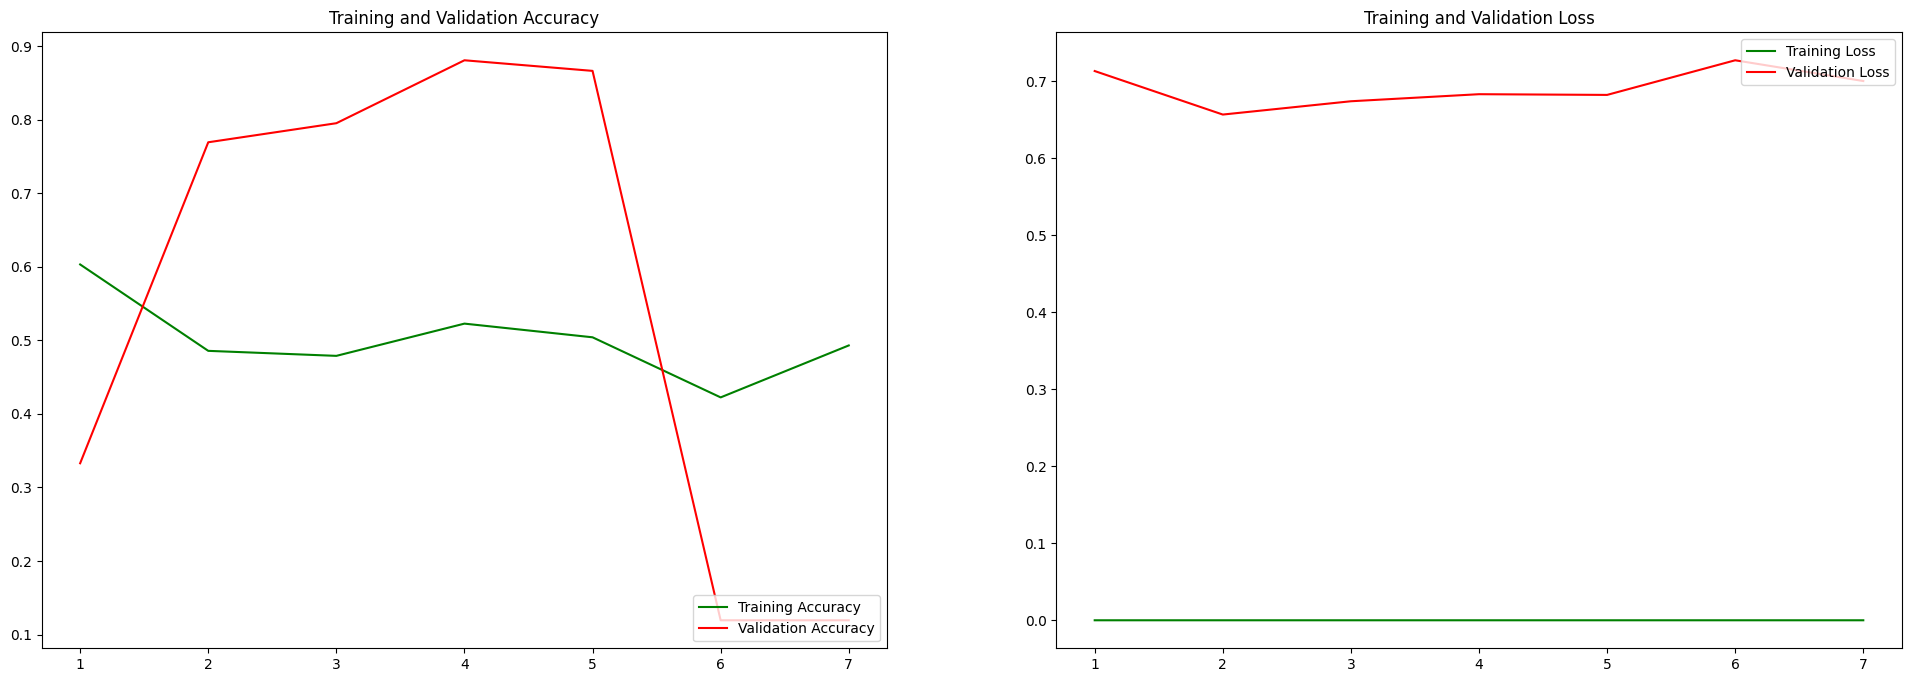

Validation Binary Accuracy is: 0.77
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6723 - binary_accuracy: 0.7477
Testing Binary Accuracy is: 0.75


In [93]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

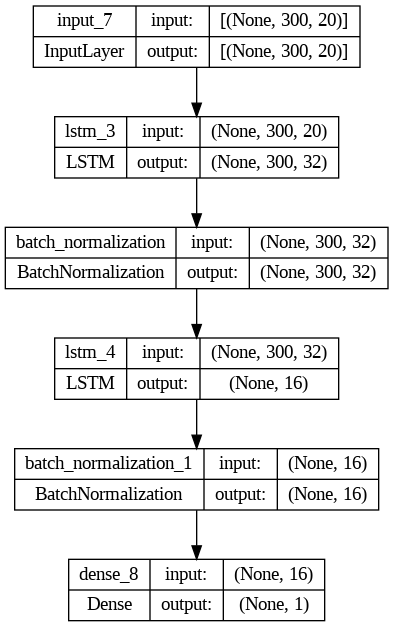

In [94]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_3, to_file='models/model_3_arch.png', show_shapes=True, show_layer_names=True)

4740/4740 [==============================] - 35s 7ms/step


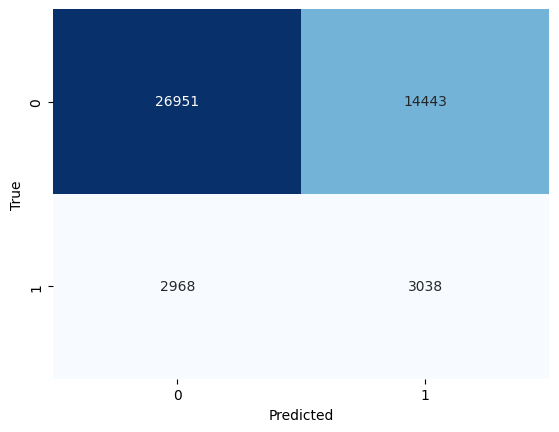

4740/4740 [==============================] - 35s 7ms/step
              precision    recall  f1-score       support
0              0.900799  0.651085  0.755851  41394.000000
1              0.173789  0.505828  0.258696   6006.000000
accuracy       0.632679  0.632679  0.632679      0.632679
macro avg      0.537294  0.578456  0.507274  47400.000000
weighted avg   0.808680  0.632679  0.692857  47400.000000
1590/1590 [==============================] - 12s 7ms/step


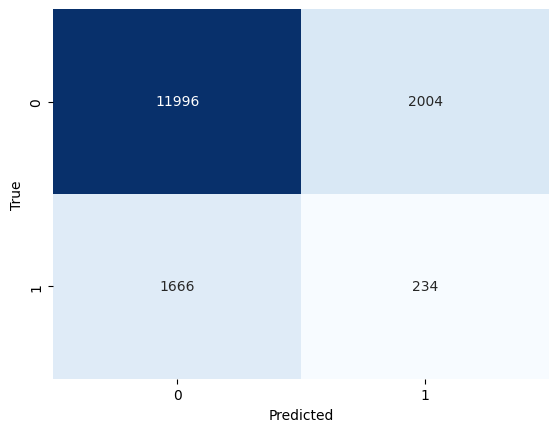

1590/1590 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.878056  0.856857  0.867327  14000.000000
1              0.104558  0.123158  0.113098   1900.000000
accuracy       0.769182  0.769182  0.769182      0.769182
macro avg      0.491307  0.490008  0.490213  15900.000000
weighted avg   0.785625  0.769182  0.777199  15900.000000
1500/1500 [==============================] - 11s 7ms/step


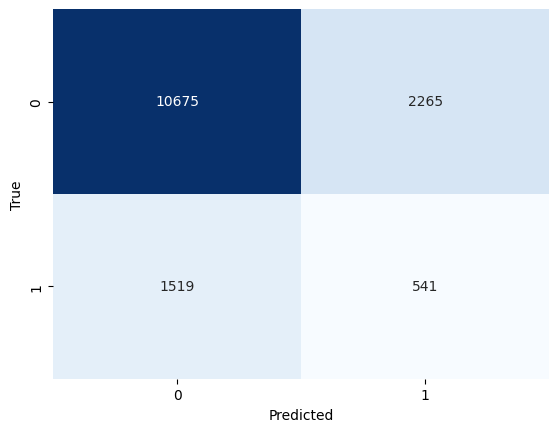

1500/1500 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.875431  0.824961  0.849447  12940.000000
1              0.192801  0.262621  0.222359   2060.000000
accuracy       0.747733  0.747733  0.747733      0.747733
macro avg      0.534116  0.543791  0.535903  15000.000000
weighted avg   0.781683  0.747733  0.763327  15000.000000


In [95]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

In [96]:
# Model 4
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=9, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=9, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(27, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [97]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [98]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 conv1d (Conv1D)             (None, 300, 9)            1629      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 9)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 9)            252       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 9)            0         
 1D)                                                             
                                                                 
 ls

1590/1590 [==============================] - 7s 4ms/step - loss: 0.6805 - binary_accuracy: 0.8805


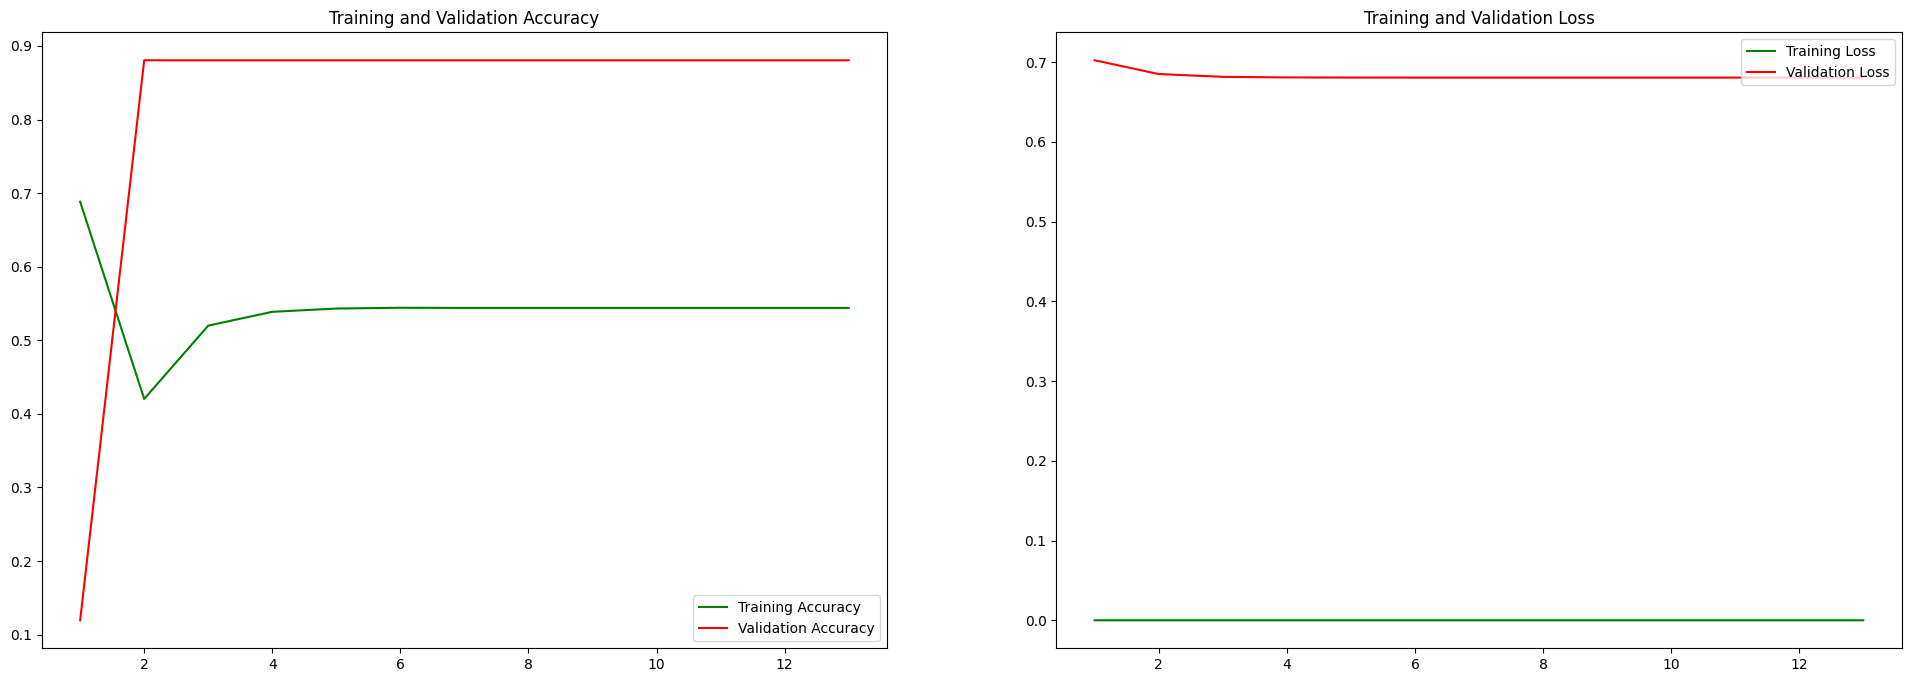

Validation Binary Accuracy is: 0.88
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6811 - binary_accuracy: 0.8627
Testing Binary Accuracy is: 0.86


In [99]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

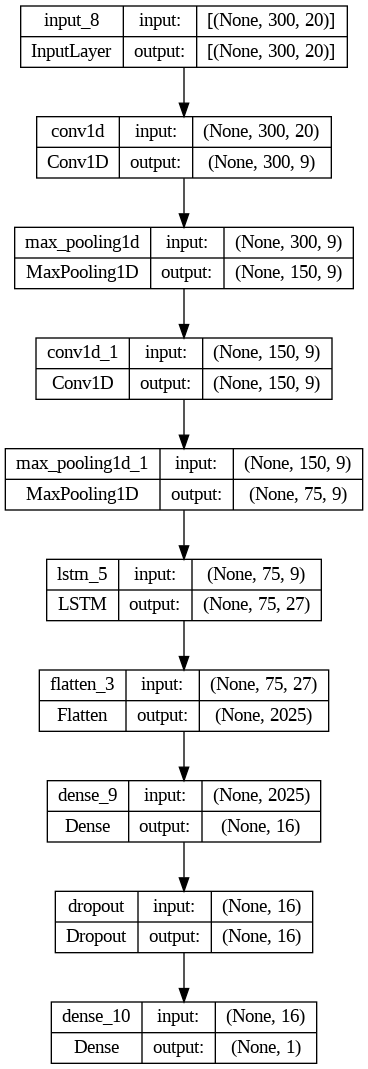

In [100]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_4, to_file='models/model_4_arch.png', show_shapes=True, show_layer_names=True)

4740/4740 [==============================] - 13s 3ms/step


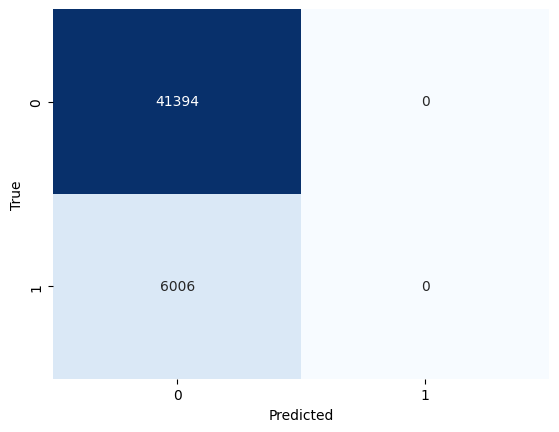

4740/4740 [==============================] - 13s 3ms/step
              precision    recall  f1-score       support
0              0.873291  1.000000  0.932360  41394.000000
1              0.000000  0.000000  0.000000   6006.000000
accuracy       0.873291  0.873291  0.873291      0.873291
macro avg      0.436646  0.500000  0.466180  47400.000000
weighted avg   0.762637  0.873291  0.814222  47400.000000
  39/1590 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1590/1590 [==============================] - 4s 3ms/step


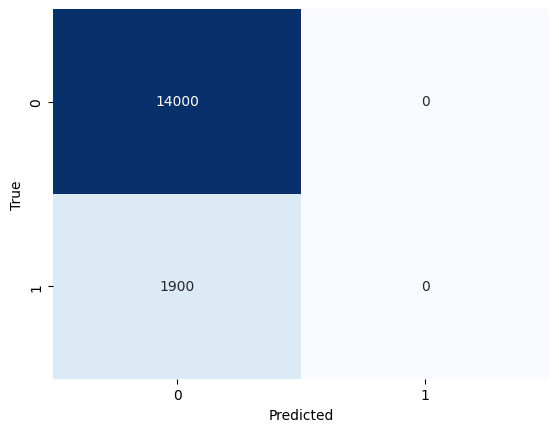

1590/1590 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.880503  1.000000  0.936455  14000.000000
1              0.000000  0.000000  0.000000   1900.000000
accuracy       0.880503  0.880503  0.880503      0.880503
macro avg      0.440252  0.500000  0.468227  15900.000000
weighted avg   0.775286  0.880503  0.824551  15900.000000
  40/1500 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1500/1500 [==============================] - 4s 3ms/step


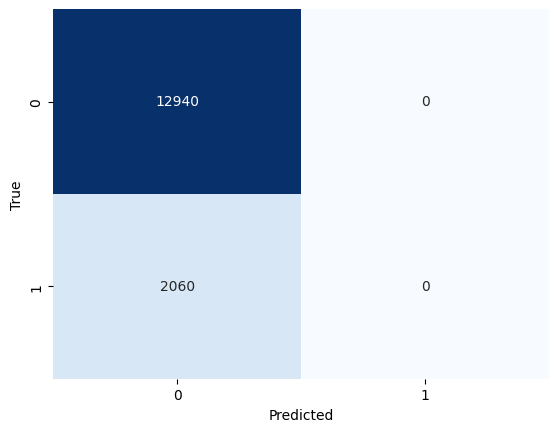

1500/1500 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.862667  1.000000  0.926271  12940.000000
1              0.000000  0.000000  0.000000   2060.000000
accuracy       0.862667  0.862667  0.862667      0.862667
macro avg      0.431333  0.500000  0.463135  15000.000000
weighted avg   0.744194  0.862667  0.799063  15000.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

In [102]:
# Model 5: Transformer LSTM
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, TransformerBlock
from tensorflow.keras.models import Model

# Define input shape
input_shape = train_gen[0][0].shape[2]))

# Define input layer
# Define the input shape
inputs = Input(seq_length, shape=input_shape)

# Add transformer block
transformer_output = TransformerBlock(64, 2)(inputs)

# Add LSTM layer
lstm_output = LSTM(32)(transformer_output)

# Add output layer
outputs = Dense(1, activation='sigmoid')(lstm_output)

# Define model
model_5 = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


SyntaxError: ignored

In [ ]:
# Model 6: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [ ]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

In [ ]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_6, to_file='models/model_6_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

In [ ]:
'''
Model_7: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)
best_learning_rate = 0.001
# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_7, to_file='models/model_7_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

In [ ]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

In [ ]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

In [39]:
# Model 8
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_lstm_model(input_shape, n_classes, head_size, num_heads, ff_dim, num_transformer_blocks, lstm_units, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # LSTM layer
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(lstm_out, head_size, num_heads, ff_dim, dropout)

    # Flatten and MLP layers
    x = layers.Flatten()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Define model hyperparameters
seq_length = 300
n_classes = 1
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
lstm_units = 64
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.5

# Build the model
model_8 = build_transformer_lstm_model(
    input_shape=(seq_length, train_gen[0][0].shape[2]),
    n_classes=n_classes,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    lstm_units=lstm_units,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
best_learning_rate = 0.001
model_8.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"]
)

# Print the model summary
model_8.summary()


NameError: ignored

In [ ]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

In [69]:
# XGBoost and Random Forests
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [70]:
X_train_2d.shape

(48600, 6000)

In [71]:
len(X_train)

48600

In [72]:
X_train = train_df.drop(['label', 'subject'], axis=1)
y_train = train_df['label']

X_val = val_df.drop(['label', 'subject'], axis=1)
y_val = val_df['label']

X_test = test_df.drop(['label', 'subject'], axis=1)
y_test = test_df['label']

In [73]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    error_score='raise',
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 150],
                         'tree_method': ['gpu_hist']},
             scoring='accuracy', verbose=3)

In [74]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)
y_test_pred = grid_search.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50, 'tree_method': 'gpu_hist'}
Train accuracy: 0.9995121951219512
Validation accuracy: 0.9068
Confusion matrix (training set):
 [[43250    20]
 [    4  5926]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43270
           1       1.00      1.00      1.00      5930

    accuracy                           1.00     49200
   macro avg       1.00      1.00      1.00     49200
weighted avg       1.00      1.00      1.00     49200

Confusion matrix (validation set):
 [[12783   232]
 [ 1166   819]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     13015
           1       0.78      0.41      0.54      1985

    accuracy                           0.91     15000
   macro avg       0.85      0.70      0.74     15000
weighted avg      

In [75]:
import pandas as pd
import numpy as np

# Get the booster object
booster = grid_search.best_estimator_.get_booster()

# Get the feature importance scores
feature_importances = booster.get_score(importance_type="weight")

# Create a dataframe to store the feature importance scores
fi_df = pd.DataFrame({'feature': list(feature_importances.keys()), 'importance': list(feature_importances.values())})

# Sort the dataframe by feature importance scores in descending order
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Print the top ten most important features
print(fi_df.head(10))

                feature  importance
8   EDA_Phasic_std_300s        36.0
6     RSP_Rate_std_300s        35.0
11   ECG_Rate_mean_300s        34.0
15       Temp_mean_300s        25.0
5    RSP_Rate_mean_300s        24.0
9     ECG_Rate_mean_60s        23.0
16        Temp_std_300s        21.0
13        Temp_mean_60s        19.0
7    EDA_Phasic_std_60s        16.0
12    ECG_Rate_std_300s        16.0


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
}

# Create a RandomForestClassifier object
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

In [77]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)
y_test_pred = grid_search.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'max_depth': 3, 'n_estimators': 50}
Train accuracy: 0.9384552845528455
Validation accuracy: 0.9006
Confusion matrix (training set):
 [[42929   341]
 [ 2687  3243]]
Classification report (training set):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     43270
           1       0.90      0.55      0.68      5930

    accuracy                           0.94     49200
   macro avg       0.92      0.77      0.82     49200
weighted avg       0.94      0.94      0.93     49200

Confusion matrix (validation set):
 [[12813   202]
 [ 1289   696]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.91      0.98      0.95     13015
           1       0.78      0.35      0.48      1985

    accuracy                           0.90     15000
   macro avg       0.84      0.67      0.71     15000
weighted avg       0.89      0.90      0.88     15000

Confusion ma